# SEN163A – Assignment 2 - Large-scale Internet Data Analysis
**DEADLINE**: Friday 18 Febary 2022 before 18:00

## Group 14
- Antonio Sanchez Martin - ''5245834''
- Felix Unger - ''5673631''
- Jeroen van Paassen - ''4720970''
- Yunus Emre Torlak - '' 5597668''

## Remarks from the lab
- The BGP routing might be very important! Lecturer hinted at this.
- Need to learn about JSON objects.
- Use the wayback machine for getting older info.
- Look at `pickle` in python for storing the data.
  - Not human-readable
  - For the `.pkl` files.
- Question 1: 
  - I.e. is the data enough?
  - You don't have to answer the questions sequentially
- Use the library `time`
  - Remember to repeat measurements to get an accurate time (as every time the code is run, it can give different results)

## Questions
1. [ ] Evaluate if there are *limitations* in the provided **datasets** (AS and probe data set). If you find limitations, describe these and conjecture possible reasons, supported with data.
   - No need to do it at the beginning! 
2. [x] With the *AS and probe data set*, **find the number *m* of AS’s that can be used for hosting** in the EU and have probes in the *RIPE data set*. Sort the **ASN’s in ascending order** and include the **first and last three** in your report (number, name and country).
3. [x] For a **single hour** in the *RIPE data set*: find all valid entries where the probe has hosting *type AS* and the *target IPv4 is from an EU country*. Implement this in an efficient way.
4. [ ] Move from using only an hour to the **full day**. It is advisable to store the raw results of each file. Then, using all processed files, *calculate the average latency’s for each country-AS* combination and store the results into one $$n_{countries}\times m$$ matrix. If we could place one server in each country, what would the *minimum average latency be for each country*? (include in your report)
5. Since we are only allowed to place four servers, determine the **best four datacenters** based on the total latency for all countries. Report your findings and your procedure to obtain them. Also include the *average latency for each country*.

In [73]:
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"



## Dataset description and loading

### Probe dataset
- It only has two columns:
  - `prb_id` -> Used to check if the probe is also in the RIPE dataset.
  - `ASN` -> Autonomous System Number (i.e. small-network id)
- Why? -> To join the RIPE and AS datasets


In [74]:
import pickle

with open("./datasets/probe_dataset.pkl", 'rb') as file:
    df_probe = pickle.load(file)

print(df_probe.shape)
df_probe.head()


(11008, 2)


,prb_id,ASN
0,1,AS3265
1,2,AS1136
2,3,AS3265
3,6,AS6830
4,8,AS3265


In [75]:
df_probe.head()

,prb_id,ASN
0,1,AS3265
1,2,AS1136
2,3,AS3265
3,6,AS6830
4,8,AS3265


In [76]:
#sorting ascending by prb_id -> Many Probe ID's missing inbetween
df_probe.sort_values(by='prb_id', ascending=True)

,prb_id,ASN
0,1,AS3265
1,2,AS1136
2,3,AS3265
3,6,AS6830
4,8,AS3265
...,...,...
11003,1000242,AS49432
11004,1000243,AS6830
11005,1000244,AS7155
11006,1000245,AS15802


### AS Dataset
- 5 columns:
  - `ASN`
  - Country code
  - Network name
  - Total number of IPs in network
  - Type of network
- Why? -> Can give us the number of IPs and location

In [77]:
import pandas
df_AS = pandas.read_pickle("./datasets/AS_dataset.pkl")
df_AS = df_AS.rename(columns={"type": "type_AS"})
df_AS.head()


,ASN,Country,Name,NumIPs,type_AS
0,AS55330,AF,AFGHANTELECOM GOVERNMENT COMMUNICATION NETWORK,"50,432",hosting
1,AS17411,AF,Io Global Services Pvt. Limited,"13,568",business
2,AS55424,AF,Instatelecom Limited,"13,312",business
3,AS38742,AF,AWCC,"11,520",isp
4,AS131284,AF,Etisalat Afghan,"10,240",isp


In [78]:
df_AS.tail()

,ASN,Country,Name,NumIPs,type_AS
60117,AS37332,ZW,Zimbabwe Online,0,education
60118,AS37344,ZW,ZIMBABWE OPEN UNIVERSITY,0,business
60119,AS37355,ZW,Zimbabwe Internet Exchange,0,business
60120,AS37391,ZW,Esmalo Enterprises,0,business
60121,AS37485,ZW,Data Control and Systems,0,business


## Question 1: Evaluate if there are limitations in the provided datasets (AS and probe data set). If you find limitations, describe these and conjecture possible reasons, supported with data

Missing values?
Data correct/consistent? - rows with 0 IPs, types of AS, plot the numIPs with the amounts 
Ae available columns/data sufficient for the analysis?

In [79]:
# Evaluate the AS dataset
# look for missing values
listings = df_AS
print(listings.isna())
# look for any missing values in any column
print(listings.isna().any().any())

# check if the same ASN values correspond with the same name / type_AS
# df_AS['ASN'].equals(df_AS['N this last one is not correctame'])

#

         ASN  Country   Name  NumIPs  type_AS
0      False    False  False   False    False
1      False    False  False   False    False
2      False    False  False   False    False
3      False    False  False   False    False
4      False    False  False   False    False
...      ...      ...    ...     ...      ...
60117  False    False  False   False    False
60118  False    False  False   False    False
60119  False    False  False   False    False
60120  False    False  False   False    False
60121  False    False  False   False    False

[60122 rows x 5 columns]
False


In [80]:
# Evaluate the probe dataset
# look for missing values
listings = df_probe
print(listings.isna())

print(listings.isna().any().any())

       prb_id    ASN
0       False  False
1       False  False
2       False  False
3       False  False
4       False  False
...       ...    ...
11003   False  False
11004   False  False
11005   False  False
11006   False  False
11007   False  False

[11008 rows x 2 columns]
False


In [81]:
# check if the same probe values correspond with the same ASN
df_probe['ASN'].equals(df_probe['prb_id'])

# we need a better way to check the probe dataset!

False

In [82]:
#checking if there are ASNs without IP numbers -> sort after column "NumIPs"
# df_AS.sort_values(by='NumIPs', ascending=False)
# only use a subset with numips==0
df_AS_only_zero = df_AS[df_AS["NumIPs"]=='0'] # subset with condition
print(len(df_AS_only_zero.index)) # count number of rows in dataframe
df_AS_only_zero.head()

15107


,ASN,Country,Name,NumIPs,type_AS
50,AS133141,AF,NetZone Limited,0,business
51,AS139697,AF,Mikrogate ICT Services Company,0,education
52,AS45521,AF,Multinet Afghanistan AS in Kandaghar,0,business
53,AS45784,AF,Multinet Afghanistan AS in Herat,0,business
54,AS45790,AF,Multinet Afghanistan AS in Mazar-E-Sharif,0,isp


In [83]:
# look at all the possible values for type_AS
# AS = df.columns.values.tolist()
# for type_AS in AS:
#     print(df.["type_AS"].unique()
print(df_AS['type_AS'].unique())


['hosting' 'business' 'isp' 'education' 'unk']


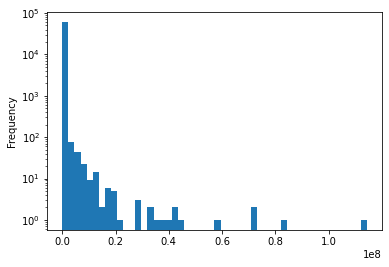

In [84]:
# plot the number of IP addresses (histogram)
import matplotlib.pyplot as plt
df_AS['NumIPs'].str.replace(",","").astype(int).plot.hist(bins=50, log=True)
plt.savefig('test.png') # save it as file
plt.show()

#Conclusion:
there are no missing values in the AS and probe dataset

-

vailable columns provide enough information for this analysis, because we are able to link it to the other provided datasets and the AS dataset provides sufficient information about the transactions.

### RIPE
**IMPORTANT** Some of the latencies are -1. No idea why. This does not make sense. This needs to be explained

In [85]:
import timeit
import pandas

file_location = './datasets/ping-2022-03-01T1000.bz2'
# Importing
df_ripe = pandas.read_json(file_location, lines = True, nrows = 1e5)
df_ripe = df_ripe.rename(columns={"type": "type_ping"})
df_ripe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   fw         100000 non-null  int64         
 1   mver       95463 non-null   object        
 2   lts        100000 non-null  int64         
 3   dst_name   100000 non-null  object        
 4   af         100000 non-null  int64         
 5   dst_addr   99532 non-null   object        
 6   src_addr   99530 non-null   object        
 7   proto      100000 non-null  object        
 8   ttl        82723 non-null   float64       
 9   size       100000 non-null  int64         
 10  result     100000 non-null  object        
 11  dup        100000 non-null  int64         
 12  rcvd       100000 non-null  int64         
 13  sent       100000 non-null  int64         
 14  min        100000 non-null  float64       
 15  max        100000 non-null  float64       
 16  avg        100000 non

In [86]:
# Check how many "from" addresses are unique
df_ripe['from'].nunique()

7161

In [87]:
%%script false --no-raise-error
# Time estimation -> Rather unreliable actually, it takes much less than that
## Note: The more lines imported in "one go", the more efficient it becomes
num_lines_to_test = 1e5
num_lines_file = sum(1 for _ in open(file_location, encoding = "ISO-8859-1")) # get the number of lines in the file
stmt = f'pandas.read_json("{file_location}", lines = True, nrows = {num_lines_to_test})' # what to run on timeit
setup = 'import pandas'
loading_time = timeit.timeit(stmt=stmt, setup=setup, number=100) # Measure how long it takes to load 100 lines 100 times on average
time_estimation = num_lines_file/num_lines_to_test*loading_time
print(f"The entire file would take {time_estimation/60} mins ({time_estimation/3600} hrs) to load")
print(f"The file has {num_lines_file} lines")


#### Things to check
- Are `dst_name` and `dst_addr` always the same? -> No!

In [88]:
# dst_name vs dst_addr
df_ripe['dst_name'].equals(df_ripe['dst_addr'])

False

The RIPE dataset contains ping measurements. This dataset contains a lot of information about these measurements that are executed by a select number of probes to most IPv4 addresses in the world. One row in this dataset (which can be seen in the table above) tells us about 

### IP datasets

#### IPv4 dataset
The IP addresses are in integer format.
- Notes: 
  - Lots of addresses don't specify a country_code or country_name. Those are removed.

Regarding the data structure of the IPv4-dataset, we are having four columns:
- `ip_to` describes the the lower boundary for a sample of IP-adresses
- `ip_to` describes the upper boundary for a sample of IP-adresses 
- `country_code` and `country_name` describe the country which belongs to the IP samples defined with `ip_to` and `ip_to`

Since the IP data was given as integeres, we converted them into IP adresses format.

In [89]:
import pandas as pd
df_ipv4 = pd.read_csv("datasets/IP2LOCATION-LITE-DB1.CSV", names=["ip_from", "ip_to", "country_code", "country_name"])
df_ipv4.drop(df_ipv4[df_ipv4["country_name"] == '-'].index, axis=0, inplace=True) # Drop rows if there is no country code
df_ipv4.dropna(inplace=True) # drop emtpy rows
df_ipv4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208494 entries, 1 to 212145
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ip_from       208494 non-null  int64 
 1   ip_to         208494 non-null  int64 
 2   country_code  208494 non-null  object
 3   country_name  208494 non-null  object
dtypes: int64(2), object(2)
memory usage: 8.0+ MB


In [90]:
# Convert int ip to, well, IP format
import ipaddress
for ip in ('ip_from', 'ip_to',):
    df_ipv4[f"{ip}_formatted"] = df_ipv4[ip].apply(ipaddress.ip_address)
print(len(df_ipv4.index))
df_ipv4.info()

208494
<class 'pandas.core.frame.DataFrame'>
Int64Index: 208494 entries, 1 to 212145
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ip_from            208494 non-null  int64 
 1   ip_to              208494 non-null  int64 
 2   country_code       208494 non-null  object
 3   country_name       208494 non-null  object
 4   ip_from_formatted  208494 non-null  object
 5   ip_to_formatted    208494 non-null  object
dtypes: int64(2), object(4)
memory usage: 11.1+ MB


#### IPv6 Dataset
- Some of the addresses aren't actually IPv4 or IPv6.
  - Example: 281473582212864 resulted in error.

In [91]:
import pandas as pd
import ipaddress
df_ipv6 = pd.read_csv("./datasets/IP2LOCATION-LITE-DB1.IPV6.CSV", names=["ip_from", "ip_to", "country_code", "country_name"])

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [92]:
df_ipv6.drop(df_ipv6[df_ipv6["country_name"] == '-'].index, axis=0, inplace=True) # Drop rows if there is no country code
df_ipv6.dropna(inplace=True)
for ip in ('ip_to', 'ip_to'):
    df_ipv6[f"{ip}_formatted"] = df_ipv6[ip].apply(lambda ip_string: ipaddress.ip_address(int(ip_string)))
print(len(df_ipv6.index))
df_ipv6.tail()

386264


,ip_from,ip_to,country_code,country_name,ip_to_formatted
445825,58569104127495754851021093355141464064,58569104206723917365285430948685414399,ZA,South Africa,2c0f:ffc8:ffff:ffff:ffff:ffff:ffff:ffff
445827,58569104761321054965135794103493066752,58569104840549217479400131697037017087,ZA,South Africa,2c0f:ffd0:ffff:ffff:ffff:ffff:ffff:ffff
445829,58569105395146355079250494851844669440,58569105474374517593514832445388619775,ZA,South Africa,2c0f:ffd8:ffff:ffff:ffff:ffff:ffff:ffff
445831,58569106662796955307479896348547874816,58569106742025117821744233942091825151,NG,Nigeria,2c0f:ffe8:ffff:ffff:ffff:ffff:ffff:ffff
445833,58569107296622255421594597096899477504,58569107375850417935858934690443427839,NG,Nigeria,2c0f:fff0:ffff:ffff:ffff:ffff:ffff:ffff


In [93]:
# Convert to int type for easy calculation
series = [int(num) for num in df_ipv6.ip_from]
type(series[0])

int

In [94]:
df_ipv6["ip_from"] = pd.Series([int(num) for num in df_ipv6.ip_from])
df_ipv6.tail()

,ip_from,ip_to,country_code,country_name,ip_to_formatted
445825,NaN,58569104206723917365285430948685414399,ZA,South Africa,2c0f:ffc8:ffff:ffff:ffff:ffff:ffff:ffff
445827,NaN,58569104840549217479400131697037017087,ZA,South Africa,2c0f:ffd0:ffff:ffff:ffff:ffff:ffff:ffff
445829,NaN,58569105474374517593514832445388619775,ZA,South Africa,2c0f:ffd8:ffff:ffff:ffff:ffff:ffff:ffff
445831,NaN,58569106742025117821744233942091825151,NG,Nigeria,2c0f:ffe8:ffff:ffff:ffff:ffff:ffff:ffff
445833,NaN,58569107375850417935858934690443427839,NG,Nigeria,2c0f:fff0:ffff:ffff:ffff:ffff:ffff:ffff


#### IP Dataset
Combination of both datasets

In [95]:
df_ip = pd.concat([df_ipv4, df_ipv6], axis=0)
df_ip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594758 entries, 1 to 445833
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ip_from            554123 non-null  object
 1   ip_to              594758 non-null  object
 2   country_code       594758 non-null  object
 3   country_name       594758 non-null  object
 4   ip_from_formatted  208494 non-null  object
 5   ip_to_formatted    594758 non-null  object
dtypes: object(6)
memory usage: 31.8+ MB


## Question 2: How many addresses are within the EU on the probe, AS and RIPE datasets?
2. With the *AS and probe data set*, **find the number *m* of AS’s that can be used for hosting** in the EU and have probes in the *RIPE data set*. Sort the **ASN’s in ascending order** and include the **first and last three** in your report (number, name and country).

- Common features in each dataset:
  - AS number:
    - AS
    - Probe
  - Probe ID:
    - Probe
    - RIPE
  - Location:
    - AS

In [96]:
# Joining the Probe and AS datasets based on the ASN
df_combined = df_AS.merge(df_probe, how='inner', on='ASN')
df_combined.head()

,ASN,Country,Name,NumIPs,type_AS,prb_id
0,AS21246,AL,IPKO Telecommunications LLC,"77,824",business,1237
1,AS21246,AL,IPKO Telecommunications LLC,"77,824",business,21795
2,AS42313,AL,Albtelecom Sh.a.,"70,912",business,2851
3,AS42313,AL,Albtelecom Sh.a.,"70,912",business,11779
4,AS42313,AL,Albtelecom Sh.a.,"70,912",business,21678


In [97]:
# Join the RIPE with the combined DF based on prb_id
df_country_codes = pandas.read_csv("./datasets/eu_country_codes.csv") # EU countries with codes
df_country_codes.head()

,ISO2,Country name
0,AL,Albania
1,AT,Austria
2,BA,Bosnia and Herzegovina
3,BE,Belgium
4,BG,Bulgaria


In [98]:
df_final = df_combined.merge(df_ripe, how='inner', on='prb_id') # Join based on prb_id
df_final_EU = df_final[df_final["Country"].isin(df_country_codes["ISO2"])] # Only EU countries
df_final_EU.sort_values(by="ASN", ascending=True, inplace=True)
df_final_EU.head()

/var/folders/j_/fksmwvvx4_3168_scxg6_7hh0000gn/T/ipykernel_23693/1712748715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_EU.sort_values(by="ASN", ascending=True, inplace=True)


,ASN,Country,Name,NumIPs,type_AS,prb_id,fw,mver,lts,dst_name,...,max,avg,msm_id,timestamp,msm_name,from,type_ping,step,group_id,ttr
31545,AS1101,NL,SURFnet bv,"1,838,592",isp,6031,5040,2.4.1,35,34.202.174.53,...,101.496105,101.479028,18764376,2022-03-01 10:02:07,Ping,145.220.0.55,ping,240.0,18764375.0,NaN
31424,AS1101,NL,SURFnet bv,"1,838,592",isp,6031,5040,2.4.1,2,27.131.108.126,...,243.052435,242.872838,29086437,2022-03-01 10:02:33,Ping,145.220.0.55,ping,240.0,29086436.0,NaN
31425,AS1101,NL,SURFnet bv,"1,838,592",isp,6031,5040,2.4.1,3,37.252.251.26,...,212.051251,212.034499,21720193,2022-03-01 10:02:34,Ping,145.220.0.55,ping,240.0,21720192.0,NaN
31426,AS1101,NL,SURFnet bv,"1,838,592",isp,6031,5040,2.4.1,3,143.129.80.132,...,6.390560,6.264755,1698328,2022-03-01 10:02:34,Ping,145.220.0.55,ping,240.0,1698328.0,NaN
31427,AS1101,NL,SURFnet bv,"1,838,592",isp,6031,5040,2.4.1,3,2001:67c:25dc:2::128:18,...,46.294893,46.109959,17332737,2022-03-01 10:02:34,Ping,2001:67c:6ec:201:145:220:0:55,ping,240.0,17332736.0,NaN


In [99]:
print(f"Number of probes in the RIPE, probe and AS datasets within the EU: {len(df_final.index)}")
df_final_EU.drop_duplicates(subset=["ASN"], inplace=True)

Number of probes in the RIPE, probe and AS datasets within the EU: 60087


/var/folders/j_/fksmwvvx4_3168_scxg6_7hh0000gn/T/ipykernel_23693/3259011321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_EU.drop_duplicates(subset=["ASN"], inplace=True)


In [100]:
# Top 3 (unique) elements
df_final_EU.loc[:, ["ASN", "Name", "Country"]].drop_duplicates(subset=['ASN']).head(3)

,ASN,Name,Country
31545,AS1101,SURFnet bv,NL
30947,AS1103,SURFnet bv,NL
24840,AS1213,HEAnet,IE


In [101]:
# Bottom 3 (unique) elements
df_final_EU.loc[:, ["ASN", "Name", "Country"]].drop_duplicates(subset=['ASN']).tail(3)

,ASN,Name,Country
9556,AS9158,Telenor A/S,DK
20530,AS9188,InfoServe GmbH,DE
20070,AS9211,Nawork Internet Informationssysteme GmbH,DE


In [102]:
# A quick test that this worked (i.e. that the merge actually behaves as expected)
prb_id = 6031
df_final_EU[df_final_EU['prb_id'] == prb_id].loc[:, ["prb_id", "ASN", "Name", "NumIPs", "Country", "type_AS"]]

,prb_id,ASN,Name,NumIPs,Country,type_AS
31545,6031,AS1101,SURFnet bv,"1,838,592",NL,isp


In [103]:
df_probe[df_probe['prb_id'] == prb_id].head()

,prb_id,ASN
1454,6031,AS1101


In [104]:
df_combined[df_combined['prb_id'] == prb_id].head()

,ASN,Country,Name,NumIPs,type_AS,prb_id
5937,AS1101,NL,SURFnet bv,"1,838,592",isp,6031


## Question 3:
- Q: For a **single hour** in the *RIPE data set*: find all valid entries where the probe has hosting *type AS* and the *target IPv4 is from an EU country*. Implement this in an efficient way.



### Initial Dataframe Information
For later comparison, the `df_final` dataframe (i.e. the combination of everything except the the IP dataframe) has been extended. Destination address (`dst_addr`) is converted to an int for easier comparison.

In [105]:
# Remove all IPv6 addresses, as they are not required for the exercise
df_final.dropna(subset=["dst_addr"], inplace=True)
df_final = df_final[~df_final["dst_addr"].str.contains(":")]
df_final.head()

,ASN,Country,Name,NumIPs,type_AS,prb_id,fw,mver,lts,dst_name,...,max,avg,msm_id,timestamp,msm_name,from,type_ping,step,group_id,ttr
0,AS21246,AL,IPKO Telecommunications LLC,"77,824",business,21795,5040,2.4.1,66,104.237.152.132,...,180.928724,180.584842,1028,2022-03-01 10:04:32,Ping,46.99.255.108,ping,240.0,NaN,NaN
1,AS21246,AL,IPKO Telecommunications LLC,"77,824",business,21795,5040,2.4.1,66,139.162.27.28,...,280.957580,278.463863,1027,2022-03-01 10:04:32,Ping,46.99.255.108,ping,240.0,NaN,NaN
2,AS21246,AL,IPKO Telecommunications LLC,"77,824",business,21795,5040,2.4.1,1,193.0.14.129,...,48.924226,47.736424,1001,2022-03-01 10:04:38,Ping,46.99.255.108,ping,240.0,NaN,NaN
3,AS42313,AL,Albtelecom Sh.a.,"70,912",business,55857,5040,2.4.1,6,198.97.190.53,...,149.230291,140.049569,1015,2022-03-01 10:03:21,Ping,217.24.242.253,ping,240.0,NaN,NaN
4,AS42313,AL,Albtelecom Sh.a.,"70,912",business,55857,5040,2.4.1,43,199.7.91.13,...,80.207041,60.719819,1012,2022-03-01 10:03:13,Ping,217.24.242.253,ping,240.0,NaN,NaN


In [106]:
# Convert all IPs to ints for comparison
import ipaddress
print(f"Length before droping Na: {len(df_final.index)}")
df_final.dropna(inplace=True, subset=['dst_addr']) # there were some NaN Values 
print(f"Length after droping Na: {len(df_final.index)}")
df_final["dst_addr_int"] = df_final["dst_addr"].apply(lambda ip_string: int(ipaddress.ip_address(ip_string))) # convert ip address to int
df_final.reset_index(inplace=True)
df_final.loc[:, ["dst_addr", "dst_addr_int"]].tail(10)

Length before droping Na: 36597
Length after droping Na: 36597


,dst_addr,dst_addr_int
36587,84.195.244.163,1422128291
36588,199.7.83.42,3339146026
36589,198.41.0.4,3324575748
36590,45.33.72.12,757155852
36591,198.97.190.53,3328294453
36592,139.162.27.28,2342656796
36593,203.174.85.106,3417199978
36594,185.28.108.163,3105647779
36595,193.0.14.129,3238006401
36596,194.156.155.241,3265043441


In [107]:
df_AS.head(3)

,ASN,Country,Name,NumIPs,type_AS
0,AS55330,AF,AFGHANTELECOM GOVERNMENT COMMUNICATION NETWORK,"50,432",hosting
1,AS17411,AF,Io Global Services Pvt. Limited,"13,568",business
2,AS55424,AF,Instatelecom Limited,"13,312",business


In [108]:
df_ip.head(3)

,ip_from,ip_to,country_code,country_name,ip_from_formatted,ip_to_formatted
1,16777216,16777471,US,United States of America,1.0.0.0,1.0.0.255
2,16777472,16778239,CN,China,1.0.1.0,1.0.3.255
3,16778240,16779263,AU,Australia,1.0.4.0,1.0.7.255


In [109]:
df_ripe.head(3)

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,avg,msm_id,prb_id,timestamp,msm_name,from,type_ping,step,group_id,ttr
0,5020,2.2.1,-1,192.36.148.17,4,192.36.148.17,172.17.0.2,ICMP,58.0,32,...,4.110618,1005,1001660,2022-03-01 10:00:47,Ping,83.243.73.91,ping,240.0,NaN,NaN
1,5020,2.2.1,-1,198.97.190.53,4,198.97.190.53,172.17.0.2,ICMP,57.0,32,...,42.569672,1015,1001660,2022-03-01 10:00:05,Ping,83.243.73.91,ping,240.0,NaN,NaN
2,5020,2.2.1,-1,202.12.27.33,4,202.12.27.33,172.17.0.2,ICMP,244.0,32,...,42.965783,1006,1001660,2022-03-01 10:01:10,Ping,83.243.73.91,ping,240.0,NaN,NaN


### Checking the timestamp of the data set for whether is it one hour or not. 

In [110]:
df_ripe_temp = df_ripe.sort_values(by=['timestamp'], ascending=True)
df_ripe_temp.head(3)

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,avg,msm_id,prb_id,timestamp,msm_name,from,type_ping,step,group_id,ttr
42284,5040,2.4.1,41,92.167.84.9,4,92.167.84.9,192.168.2.113,ICMP,NaN,48,...,-1.000000,24747054,51251,2022-03-01 10:00:00,Ping,85.221.145.56,ping,240.0,24747054.0,NaN
4984,4790,NaN,388,78.46.48.134,4,78.46.48.134,192.168.1.206,ICMP,53.0,20,...,30.695942,1017,2317,2022-03-01 10:00:00,Ping,86.150.96.205,ping,240.0,NaN,NaN
228,5040,2.4.1,-1,2610:a1:305c:252::254,6,2610:a1:305c:252::254,2001:67c:1220:9892:222:64ff:fe11:db1d,ICMP,48.0,64,...,239.094563,29777641,1000564,2022-03-01 10:00:00,Ping,2001:67c:1220:9892:222:64ff:fe11:db1d,ping,240.0,29777640.0,NaN


In [111]:
df_ripe_temp.tail(3)

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,avg,msm_id,prb_id,timestamp,msm_name,from,type_ping,step,group_id,ttr
721,5000,2.2.0,-1,202.12.27.33,4,202.12.27.33,192.168.100.3,ICMP,245.0,20,...,29.626519,1006,1000057,2022-03-01 10:59:45,Ping,90.177.221.181,ping,240.0,NaN,NaN
282,5040,2.4.1,-1,2001:500:2f::f,6,2001:500:2f::f,2001:67c:1220:9892:222:64ff:fe11:db1d,ICMP,57.0,32,...,3.748710,2004,1000564,2022-03-01 10:59:53,Ping,2001:67c:1220:9892:222:64ff:fe11:db1d,ping,240.0,NaN,NaN
226,5040,2.4.1,-1,2a01:4f8:110:13cd::2,6,2a01:4f8:110:13cd::2,2605:c640:10c8:113::92,ICMP,51.0,32,...,241.802006,2017,1001186,2022-03-01 10:59:55,Ping,2605:c640:10c8:113::92,ping,240.0,NaN,NaN


### Select only EU countries in the IP dataset

In [112]:
# Ipv4 for only EU coutries
df_ipv4_EU = df_ipv4[df_ipv4["country_code"].isin(df_country_codes["ISO2"])]
df_ipv4_EU.reset_index(inplace=True)
print(df_ipv4_EU.loc[8, :])
df_ipv4_EU.head(10)

index                       113
ip_from                34605312
ip_to                  34605567
country_code                 DE
country_name            Germany
ip_from_formatted      2.16.9.0
ip_to_formatted      2.16.9.255
Name: 8, dtype: object


,index,ip_from,ip_to,country_code,country_name,ip_from_formatted,ip_to_formatted
0,78,28233472,28233727,NO,Norway,1.174.207.0,1.174.207.255
1,89,28499968,28508159,ES,Spain,1.178.224.0,1.178.255.255
2,97,28536832,28540927,FR,France,1.179.112.0,1.179.127.255
3,106,33554432,34603263,FR,France,2.0.0.0,2.16.0.255
4,107,34603264,34603519,PL,Poland,2.16.1.0,2.16.1.255
5,109,34603776,34604031,FR,France,2.16.3.0,2.16.3.255
6,111,34604544,34605055,DE,Germany,2.16.6.0,2.16.7.255
7,112,34605056,34605311,ES,Spain,2.16.8.0,2.16.8.255
8,113,34605312,34605567,DE,Germany,2.16.9.0,2.16.9.255
9,114,34605568,34605823,AT,Austria,2.16.10.0,2.16.10.255


### **SKIP: NOT USED ANYMORE**Select only entries in the RIPE dataset that are in EU countries
- Notes: 
  - This is an absolute pain in the ass.
    - It has to be memory efficient, so we cannot just store all of the possible IP values.
    - IP addresses cannot be stored as ints, as they are too big!
- The float conversion is not perfect, but it is good enough for this approach (hopefully)
  - NOPE! The introduced error is too large
- In theory, python's ints can be as large as needed (i.e. there is no loss of info). However, pandas seems to disagree. Therefore, we have to deal with the built-in python lists.

In [113]:
%%script false --no-raise-error
# Get int lists for calculations
import numpy as np
ip_ip_to = df_ip_EU['ip_to'].to_list()
ip_ip_to = np.array([int(number) for number in ip_ip_to])
print(ip_ip_to[0])
print(df_ip_EU.ip_to.iloc[0])
print(ip_ip_to[-1])
print(int(df_ip_EU.ip_to.iloc[-1]))
print(df_ip_EU.ip_to.iloc[-1])

print("\n")
final_hosting_dst_addr = df_final_hosting.dst_addr_int.to_list()
final_hosting_dst_addr = np.array([int(number) for number in final_hosting_dst_addr])
print(final_hosting_dst_addr[0])
print(df_final_hosting.dst_addr_int.iloc[0])
print(final_hosting_dst_addr[-1])
print(int(df_final_hosting.dst_addr_int.iloc[-1]))
print(df_final_hosting.dst_addr_int.iloc[-1])

In [114]:
%%script false --no-raise-error
# Find positive value closest to zero
# ip_address= 471826
# Random Sample
example = df_final_hosting.sample(n=1)
ip_address = int(example.dst_addr_int)

In [115]:
%%script false --no-raise-error
list_subtraction = ip_ip_to - ip_address # subtract the desired ip address from the ip_from list; if"close" to zero, then maybe it's within range.
list_subtraction = np.where(list_subtraction < 0, np.inf, list_subtraction) # replace all negative values by infinity 
index = np.argmin(np.abs(list_subtraction))
ip_from_temp = int(df_ipv4_EU["ip_from"].iloc[index])
ip_to_temp = int(df_ipv4_EU["ip_to"].iloc[index])
result = True if ip_address > ip_from_temp else False
print(result)
print(ip_from_temp)\
print(ip_address)
print(ip_to_temp)
print(index)

### Select only entries in the RIPE dataset that are in EU countries

In [116]:
# Module for dealing with the database
import IP2Location
ip_database = IP2Location.IP2Location('./datasets/IP2LOCATION-LITE-DB1.BIN')
ip_database.get_country_short('1.179.112.0') # this should be FR


'FR'

In [117]:
df_final["dst_addr_country"] = df_final["dst_addr"].apply(lambda addr: ip_database.get_country_short(addr))
df_final.head()

,index,ASN,Country,Name,NumIPs,type_AS,prb_id,fw,mver,lts,...,msm_id,timestamp,msm_name,from,type_ping,step,group_id,ttr,dst_addr_int,dst_addr_country
0,0,AS21246,AL,IPKO Telecommunications LLC,"77,824",business,21795,5040,2.4.1,66,...,1028,2022-03-01 10:04:32,Ping,46.99.255.108,ping,240.0,NaN,NaN,1760401540,US
1,1,AS21246,AL,IPKO Telecommunications LLC,"77,824",business,21795,5040,2.4.1,66,...,1027,2022-03-01 10:04:32,Ping,46.99.255.108,ping,240.0,NaN,NaN,2342656796,SG
2,2,AS21246,AL,IPKO Telecommunications LLC,"77,824",business,21795,5040,2.4.1,1,...,1001,2022-03-01 10:04:38,Ping,46.99.255.108,ping,240.0,NaN,NaN,3238006401,NL
3,3,AS42313,AL,Albtelecom Sh.a.,"70,912",business,55857,5040,2.4.1,6,...,1015,2022-03-01 10:03:21,Ping,217.24.242.253,ping,240.0,NaN,NaN,3328294453,US
4,4,AS42313,AL,Albtelecom Sh.a.,"70,912",business,55857,5040,2.4.1,43,...,1012,2022-03-01 10:03:13,Ping,217.24.242.253,ping,240.0,NaN,NaN,3339148045,US


In [118]:
# Select only hosting types
df_final_hosting = df_final[df_final["type_AS"] == 'hosting']
df_final_hosting

,index,ASN,Country,Name,NumIPs,type_AS,prb_id,fw,mver,lts,...,msm_id,timestamp,msm_name,from,type_ping,step,group_id,ttr,dst_addr_int,dst_addr_country
80,101,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,813,...,23569903,2022-03-01 10:05:02,Ping,200.61.6.78,ping,240.0,23569902.0,NaN,1733126403,ID
81,102,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,816,...,29163283,2022-03-01 10:05:05,Ping,200.61.6.78,ping,240.0,29163282.0,NaN,2854699333,US
82,103,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,818,...,23143070,2022-03-01 10:05:07,Ping,200.61.6.78,ping,240.0,23143069.0,NaN,3064023065,HK
83,104,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,820,...,29416108,2022-03-01 10:05:09,Ping,200.61.6.78,ping,240.0,29416107.0,NaN,1348238481,AT
84,105,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,821,...,24744467,2022-03-01 10:05:10,Ping,200.61.6.78,ping,240.0,24744466.0,NaN,1249343487,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36589,60079,AS14434,VI,"VI POWERNET, LLC","51,456",hosting,12541,5040,2.4.1,9,...,1009,2022-03-01 10:05:17,Ping,66.248.183.139,ping,240.0,NaN,NaN,3324575748,US
36590,60080,AS14434,VI,"VI POWERNET, LLC","51,456",hosting,12541,5040,2.4.1,19,...,1029,2022-03-01 10:05:42,Ping,66.248.183.139,ping,240.0,NaN,NaN,757155852,US
36591,60081,AS14434,VI,"VI POWERNET, LLC","51,456",hosting,12541,5040,2.4.1,38,...,1015,2022-03-01 10:04:14,Ping,66.248.183.139,ping,240.0,NaN,NaN,3328294453,US
36592,60082,AS14434,VI,"VI POWERNET, LLC","51,456",hosting,12541,5040,2.4.1,6,...,1027,2022-03-01 10:05:29,Ping,66.248.183.139,ping,240.0,NaN,NaN,2342656796,SG


In [119]:
# Select only if the dst_addr_country is in the EU
df_final_hosting_EU = df_final_hosting[df_final_hosting["dst_addr_country"].isin(df_country_codes["ISO2"])]
df_final_hosting_EU.head()

,index,ASN,Country,Name,NumIPs,type_AS,prb_id,fw,mver,lts,...,msm_id,timestamp,msm_name,from,type_ping,step,group_id,ttr,dst_addr_int,dst_addr_country
83,104,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,820,...,29416108,2022-03-01 10:05:09,Ping,200.61.6.78,ping,240.0,29416107.0,NaN,1348238481,AT
87,108,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,815,...,26527667,2022-03-01 10:05:04,Ping,200.61.6.78,ping,240.0,26527666.0,NaN,1439353801,CH
88,109,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,819,...,26623453,2022-03-01 10:05:08,Ping,200.61.6.78,ping,240.0,26623452.0,NaN,3224130307,DE
91,112,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,848,...,25910849,2022-03-01 10:05:37,Ping,200.61.6.78,ping,240.0,25910848.0,NaN,3247250396,DE
97,118,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,862,...,26294752,2022-03-01 10:05:51,Ping,200.61.6.78,ping,240.0,26294751.0,NaN,1539235938,DE


In [133]:
# Remove all latencies that are -1
df_final_hosting_EU.drop(df_final_hosting_EU[df_final_hosting_EU["avg"] == -1].index, inplace=True) # Drop rows if there is no country code
df_final_hosting_EU.head()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,index,ASN,Country,Name,NumIPs,type_AS,prb_id,fw,mver,lts,...,msm_id,timestamp,msm_name,from,type_ping,step,group_id,ttr,dst_addr_int,dst_addr_country
83,104,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,820,...,29416108,2022-03-01 10:05:09,Ping,200.61.6.78,ping,240.0,29416107.0,NaN,1348238481,AT
87,108,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,815,...,26527667,2022-03-01 10:05:04,Ping,200.61.6.78,ping,240.0,26527666.0,NaN,1439353801,CH
88,109,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,819,...,26623453,2022-03-01 10:05:08,Ping,200.61.6.78,ping,240.0,26623452.0,NaN,3224130307,DE
91,112,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,848,...,25910849,2022-03-01 10:05:37,Ping,200.61.6.78,ping,240.0,25910848.0,NaN,3247250396,DE
97,118,AS11193,AR,COMNET S.A.,"2,816",hosting,6678,5040,2.4.1,862,...,26294752,2022-03-01 10:05:51,Ping,200.61.6.78,ping,240.0,26294751.0,NaN,1539235938,DE


## Q4: Average latency for each country-As combination
4. [ ] Move from using only an hour to the **full day**. It is advisable to store the raw results of each file. Then, using all processed files, *calculate the average latency’s for each country-AS* combination and store the results into one $$n_{countries}\times m$$ matrix. If we could place one server in each country, what would the *minimum average latency be for each country*? (include in your report)
<!-- 5. [ ] Since we are only allowed to place four servers, determine the **best four datacenters** based on the total latency for all countries. Report your findings and your procedure to obtain them. Also include the *average latency for each country*. -->
- Notes:
  - The average round-trip time is `avg`

In [134]:
list_country = list(pd.unique(df_final_hosting_EU["dst_addr_country"]))
list_ASN = list(pd.unique(df_final_hosting_EU["ASN"]))
print(len(list_country))
print(len(list_ASN))

29
102


In [135]:
# Creating the latency array
import numpy as np
latency_array = np.zeros([len(list_country), len(list_ASN)])

country_counter = 0
for country in list_country:
    df_subset = df_final_hosting_EU[df_final_hosting_EU.dst_addr_country==country] # dataframe for specific country
    country_specific_ASN = pd.unique(df_subset['ASN']) # get all of the ASNs present in the country
    ASN_counter = 0
    for ASN in list_ASN: # iterate through the ASN list
        if ASN in country_specific_ASN: # if the current ASN is present in the country, calculate the average (of the average) ping
            temp = df_subset[df_subset["ASN"] == ASN]
            # print(temp)
            average_latency_of_ASN = np.mean(temp["avg"].to_numpy())
            latency_array[country_counter, ASN_counter] = average_latency_of_ASN
        ASN_counter += 1 
    country_counter += 1

In [140]:
# Example latency array for each country
print(latency_array[0, :])

[246.87840783   0.           0.          28.32598033   0.
   0.           0.           0.           0.           5.318973
  18.55875067   0.           0.          32.01836133   0.
   0.           0.           0.           0.         105.33176167
   0.          27.96273933   0.           0.           0.
  37.12563967   0.          19.54913783  27.2120425    0.
   0.           0.           0.           0.           0.
   0.           0.           0.           9.820968    21.299505
  20.732353    18.272399     0.           0.           0.
   0.           0.           0.         285.07466667   0.
 108.651891     0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.          16.87392633   0.          24.81012722   0.
   0.          46.12595033   0.           0.           0.
  64.64705317   0.           0.           0.           0.
   0.           0.           0.          34.74223778   0.
   0.           0.          13.76546     13.075001  

In [137]:
# Calculate average for each country
average_latency = list()
for country in latency_array:
    average_latency.append(np.sum(country)/np.count_nonzero(country))
print(len(average_latency))

29


In [138]:
# Convert to pandas dataframe
d = {"ISO2": list_country, "average_latency": average_latency}
df_latency = pd.DataFrame(data=d)
df_latency = df_country_codes.merge(df_latency, on='ISO2')
df_latency.head(10)

,ISO2,Country name,average_latency
0,AL,Albania,72.885425
1,AT,Austria,50.763431
2,BA,Bosnia and Herzegovina,51.890419
3,BE,Belgium,34.482437
4,BG,Bulgaria,68.008961
5,CH,Switzerland,60.462143
6,DE,Germany,51.103738
7,DK,Denmark,61.591177
8,EE,Estonia,34.845194
9,ES,Spain,56.364494


###  Q5: 
5. [ ] Since we are only allowed to place four servers, determine the **best four datacenters** based on the total latency for all countries. Report your findings and your procedure to obtain them. Also include the *average latency for each country*. 

In [139]:
# Output the 4 countries withh the least latency
df_latency.sort_values(by="average_latency", ascending=True, inplace=True)
df_latency.head(4)


,ISO2,Country name,average_latency
15,IE,Ireland,23.878767
28,SI,Slovenia,32.270388
3,BE,Belgium,34.482437
8,EE,Estonia,34.845194
